# Tutorial 03 - Filters
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/03_Filters.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in general programming** and aims to introduce you to Computer Vision techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Contents

** ToDo **

Table of Contents  
- [Filters in OpenCV](#Filters)
    - Reading images
    - Channel and Image Formats
    - Showing images
    - Color channels
    - Manipulating images
    - Writing images
    - ...
- [Fourier Transformation](#Fourier_Transformation)

# Initilization

As always let's import useful libraries, first.

In [2]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt

We will work with images today. So let's download some with `curl` (the same sources as in `02_OpenCV.ipynb`).

In [3]:
!curl -o "cat.jpg" "https://placekitten.com/256/256"

!curl -o "gogh.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Vincent_van_Gogh_-_National_Gallery_of_Art.JPG/367px-Vincent_van_Gogh_-_National_Gallery_of_Art.JPG"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5669    0  5669    0     0  10716      0 --:--:-- --:--:-- --:--:-- 10696
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84904  100 84904    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k


Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [4]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab.patches import cv2_imshow
else:
  print('Not running on CoLab')
  def cv2_imshow(img):
      """A replacement for cv2.imshow() for use in Jupyter notebooks.

        Args:
          img : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
      """
      cv2.imshow('image', img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

Running on CoLab


# Filters

Image filters in OpenCV are applied with `cv2.filter2D(img,-1,kernel)`, where the image and the kernel are numpy arrays.


## Average

Let's start with a simple average filter

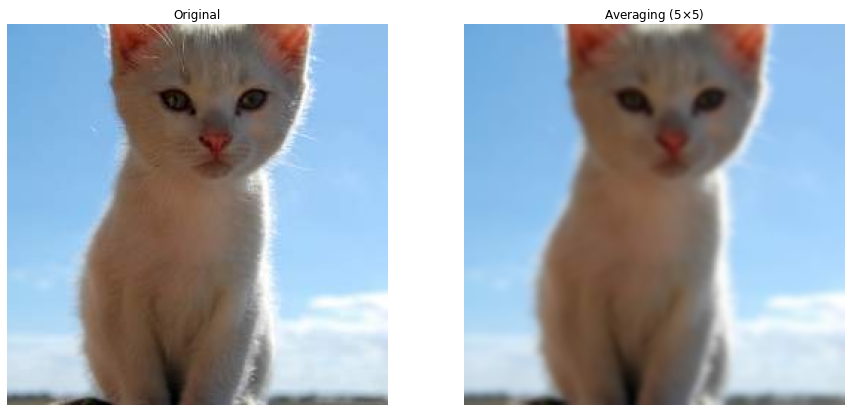

In [5]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size
kernel = np.ones((k,k),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the filter results clearer
plt.subplot(121),imshow(img),plt.title('Original')
plt.subplot(122),imshow(dst),plt.title(r'Averaging ({}$\times${})'.format(k,k))
plt.show()

## Gaussian Filter

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


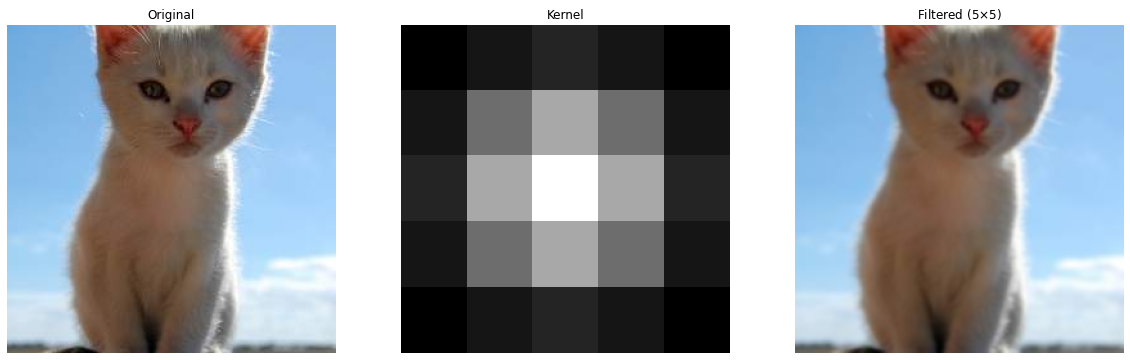

In [6]:
img = cv2.imread('cat.jpg')

k = 5 # kernel size and sigma
kernel = cv2.getGaussianKernel(k,-1)
#print(kernel.T)
kernel = kernel @ kernel.T # compute 2D from seperable kernel
print(kernel)
dst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(20,15)) # make the figure larger
plt.subplot(131),imshow(img),plt.title('Original')
plt.subplot(132),imshow(kernel, cmap = 'gray'),plt.title('Kernel')
plt.subplot(133),imshow(dst),plt.title(r'Filtered ({}$\times${})'.format(k,k))
plt.show()

## Naive image resizing 
… by simply throwing away rows and columns (see lecture slides).
We can use Python's slicing notation do to so.

In [7]:
def downsample( img ):
    return img[0::2,0::2]

half = downsample(image)    # 1/2 resolution
quad = downsample(half)     # 1/4
eighth = downsample(quad)   # 1/8
imshow(image)
#imshow(half)
#imshow(quad)
imshow(eighth)

NameError: ignored

Dropping pixels is not a good way to downscale images. It leads to severe aliasing problems (see lecture slides). 

Let's look compare to a downsampled image by OpenCV's built-in `resize` function.

In [ ]:
smooth = cv2.resize(image, eighth.shape[1::-1], interpolation=cv2.INTER_AREA)
imshow(smooth)

This looks nicer and does not show any aliasing artefacts. We will discuss the details in the upcoming lectures!

# Fourier Spectrum

## Fourier Transformation of Images

The numpy library provides a two-dimensional implementation of the Fast Fourier Transformation (FFT): `numpy.fft.fft2`. 
The resulting spectrum is an array with complex numbers, which are supported by numpy. 
We can visualize the spectrum by displaying it like a regular image. Since it is complex we will show only the magnitude (with `numpy.abs`) and we'll use a logarithmic scale. 

dtype('complex128')


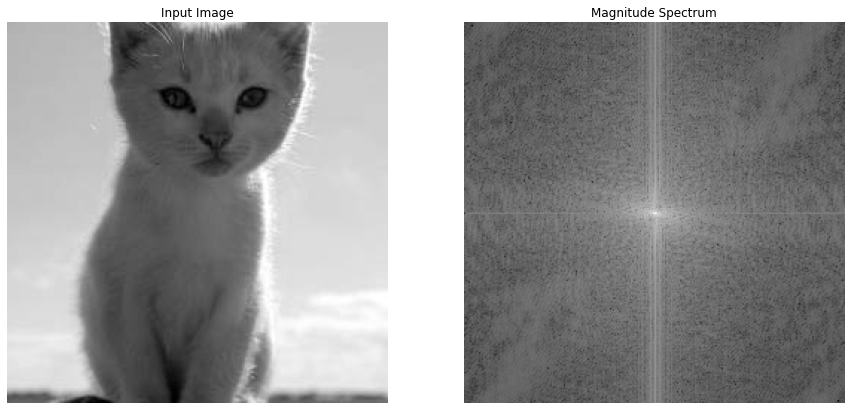

In [64]:
# Load an image and convert it to grayscale
gray = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)

# Transform the image to frequency domain
f = np.fft.fft2(gray)
print(repr(f.dtype))
# Bring the zero-frequency component to the center
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(gray, cmap = 'gray'), plt.title('Input Image')
plt.subplot(122), imshow(magnitude_spectrum, cmap = 'gray'), plt.title('Magnitude Spectrum')
plt.show()

## Inverse Fourier Transformation

While the FFT transform a signal into its spectral domain, the inverse FFT (`numpy.fft.ifft2`) transforms a spectrum into the spatial domain. Note that the resulting array is complex again, where the complex part is zero (or close to zero). 

complex128


(<Figure size 1080x720 with 1 Axes>, None, Text(0.5, 1.0, 'Inverse FFT'))

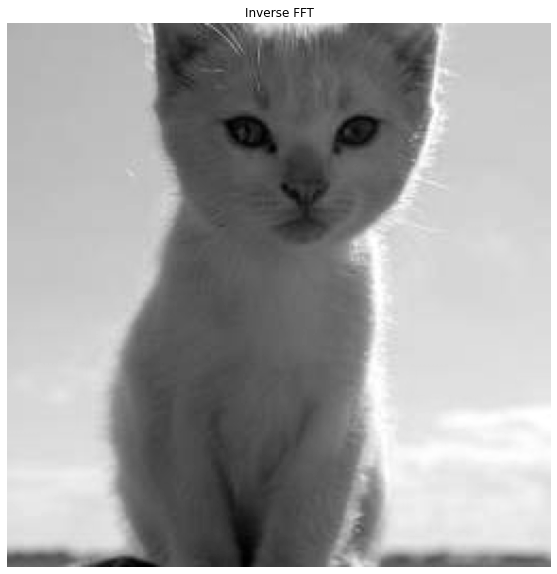

In [32]:
# inverse fourier transform
iff = np.fft.ifft2(f)
print(iff.dtype)
#print(repr(iff))

plt.figure(figsize=(15,10)), imshow(np.abs(iff), cmap='gray'), plt.title('Inverse FFT')

Let's look at some artificial spectra and the corresponding signal. 

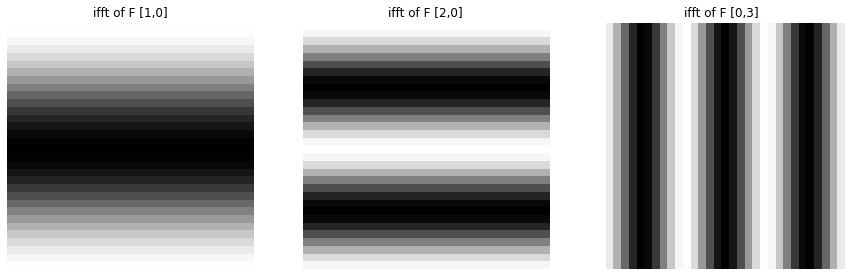

In [69]:
F = np.zeros((32,32),dtype=np.complex128)
F[0,0] = np.prod(F.shape) # DC component (mean)
F10 = F.copy()
F10[1,0] = 1.0
f10 = np.fft.ifft2(F10)

F20 = F.copy()
F20[2,0] = 1.0
f20 = np.fft.ifft2(F20)

F03 = F.copy()
F03[0,3] = 1.0
f03 = np.fft.ifft2(F03)

plt.figure(figsize=(15,10))
plt.subplot(131), imshow(np.abs(f10), cmap='gray'), plt.title('ifft of F [1,0]')
plt.subplot(132), imshow(np.abs(f20), cmap='gray'), plt.title('ifft of F [2,0]')
plt.subplot(133), imshow(np.abs(f03), cmap='gray'), plt.title('ifft of F [0,3]')
plt.show()

## Modifications in the Fourier Spectrum

Let's remove some frequencies by setting them to zero in the spectrum. By converting the spectrum back in the spatial domain (`ifft2`) we can look at the results in the image.

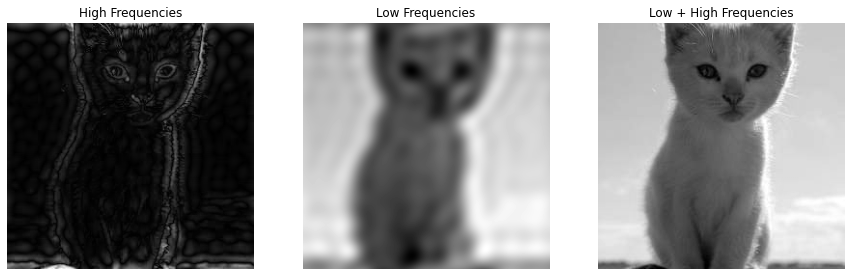

In [29]:
rows, cols = gray.shape
crow, ccol = round(rows/2) , round(cols/2)

# remove low frequencies with a rectangle size of 10
fcopy = fshift.copy()
fcopy[crow-10:crow+10, ccol-10:ccol+10] = 0
f_ishift = np.fft.ifftshift(fcopy)
img_hf = np.fft.ifft2(f_ishift)
plt.figure(figsize=(15,10))
plt.subplot(131), plt.title( 'High Frequencies')
imshow(np.abs(img_hf), cmap='gray')

# remove high frequencies
fcopy = np.zeros_like(fshift)
fcopy[crow-10:crow+10, ccol-10:ccol+10] = fshift[crow-10:crow+10, ccol-10:ccol+10]
f_ishift = np.fft.ifftshift(fcopy)
img_lf = np.fft.ifft2(f_ishift)
plt.subplot(132), plt.title( 'Low Frequencies')
imshow(np.abs(img_lf), cmap='gray')

# sum the low and high frequencies (Note: it is important to avoid abs)
plt.subplot(133), plt.title( 'Low + High Frequencies')
imshow(np.abs(img_lf+img_hf), cmap='gray')

# Convolutions in the Fourier Spectrum

 

## Convolution as Point-Wise Operation in the Spectral Domain

A convolution is a point-wise operation in the spectral domain. Let's try this with our images. 
For very large kernels OpenCV's filter function uses FFT to speed up computations.

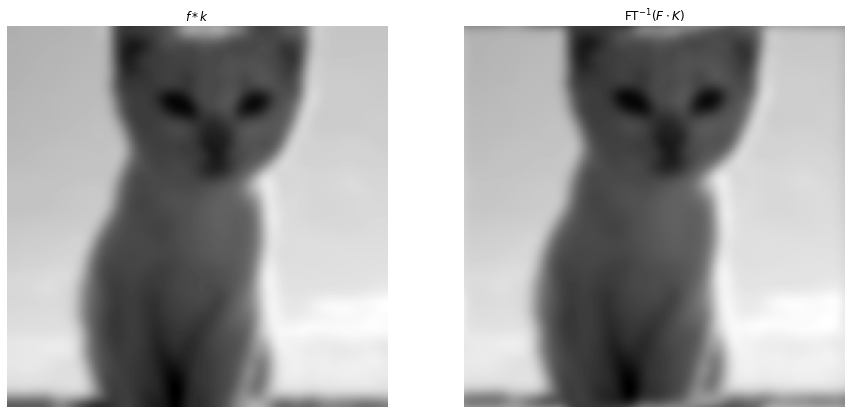

In [93]:
# Load an image and convert it to grayscale
f = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_RGB2GRAY)
# Transform the image to frequency domain
F = np.fft.fft2(f)

rows, cols = f.shape
crow, ccol = round(rows/2) , round(cols/2)

# create a kernel
k_size = 25 # kernel size and sigma
kh = int(np.floor(k_size/2.0))
kernel = cv2.getGaussianKernel(k_size,-1) 
kernel = kernel @ kernel.T # compute 2D from seperable kernel
k = np.zeros(f.shape)
k[crow-kh-1:crow+kh, ccol-kh-1:ccol+kh] = kernel # extend the size of the kernel
K = np.fft.fft2(k)

# apply the convolution in the spatial domain
d = cv2.filter2D(f,-1,k)

# apply a multiplication in the frequency domain
D = np.zeros_like(F)
D = F * K
D_back = np.fft.ifftshift(np.fft.ifft2(D))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(np.abs(d), cmap='gray'), plt.title('$f * k$')
plt.subplot(122), imshow(np.abs(D_back), cmap='gray'), plt.title(r'FT$^{-1}( F \cdot K )$')
#plt.subplot(133), imshow(np.abs(f03), cmap='gray'), plt.title('ifft of F [0,3]')
plt.show()

Similarly, a convolution in the frequency domain corresponds to a multiplication in the spatial domain.

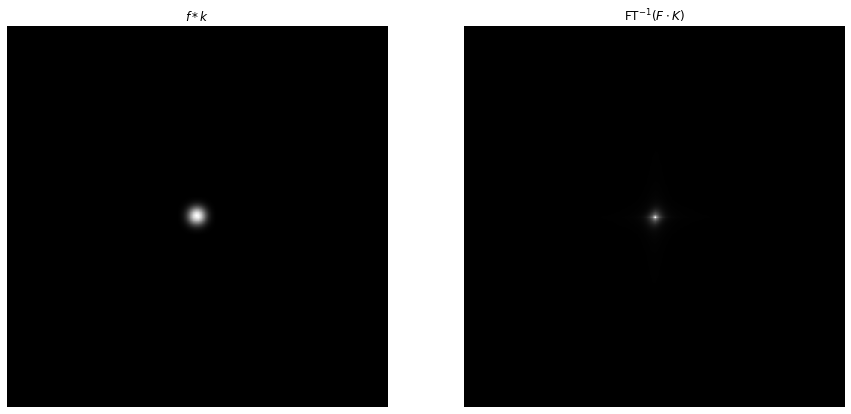

In [96]:

# apply a multiplication in the spatial domain
g = f * k

# apply a convolution in the frequency domain
G = cv2.filter2D(np.abs(F),-1,np.abs(K))
G_back = np.fft.ifftshift(np.fft.ifft2(G))

plt.figure(figsize=(15,10))
plt.subplot(121), imshow(np.abs(g), cmap='gray'), plt.title('$f * k$')
plt.subplot(122), imshow(np.abs(G_back), cmap='gray'), plt.title(r'FT$^{-1}( F \cdot K )$')
#plt.subplot(133), imshow(np.abs(f03), cmap='gray'), plt.title('ifft of F [0,3]')
plt.show()

# Exercises (Try it yourself)

## Exercise 1

**Grayscale:** Color is nice, but monochrome images are also very appealing.
Displaying a single color channel does not really look nice. So we need a weighted sum of all channels.
Typical weights to convert from RGB to grayscale are: 
> $0.2989 * R + 0.5870 * G + 0.1140 * B$

**(a)** Load the image `gogh.jpg`. Convert it to grayscale and display it. Don't forget that channels are BGR.



In [ ]:
# Solution (a)


## Exercise 2

**Gamma Curve:** 8-bit images are stored non-linear (like our perception). \
A common function used for this non-linear linear mapping is the gamma curve: $ y = x^\gamma $, where $x$ are the linear values in the range \[0,1\]. Gamma is $\gamma=2.2$ on most systems.

**(a)** Linearize the image and display it. Note that displaying a linear image might look weird. \
**(b)** Apply different $\gamma$ (i.e., 0.5, 1.0, and 1.5) and see whats happening.

In [ ]:
# Solution (a)


In [ ]:
# Solution (b)
